# Library Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline


# Sim Plots

## Transient 

In [3]:
def plot_tran(path):
    # Load Xyce output
    d = pd.read_csv(path, delim_whitespace=True, comment="*")
    d.drop(len(d)-1, axis=0, inplace=True)
    for c in d.columns:
        d[c] = d[c].astype(float)

    fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True, dpi=200)
    for c in d.columns[2:]:
        if c[0] == "I":
            axs[0].plot(d["TIME"].values, d[c].values, label=c)
            axs[0].axhline(0, color="red", lw=0.5)
            axs[0].set_ylabel("Current (A)")
            axs[0].set_title("Current vs Time")
            axs[0].legend()
            axs[0].grid()

        else:
    # Second subplot
            axs[1].plot(d["TIME"].values, d[c].values, label=c)
            axs[1].set_xlabel("Time (s)")
            axs[1].set_ylabel("Voltage (V)")
            axs[1].set_title(f"{c} vs Time")
            axs[1].legend()
            axs[1].grid()
    plt.show()

    return d

In [ ]:
# waveform_path = MC_<attack_type>_<hammer_count>HC_<N>samples_<timestamp>/array_<subarray_size>_<col>_<iter>.cir.prn
waveform_path = ''
plot_tran(waveform_path)

# Experimental Data

### HCfirst

In [ ]:
# expecded format: ...HCfirst.csv
# labels: 'Row', 'Column', 'Hammer Count', 'Iter' , 'Test', 'Side', 'Off Time', (optional: 'On Time', 'Temperature')
experiment_path = ''
df = pd.read_csv(experiment_path)

In [ ]:
ss = df[df["Test"] == "single"].groupby(["Pivot Row", "Off Time", ]).min().reset_index()
ds = df[df["Test"] == "double"].groupby(["Pivot Row", "Off Time"]).min().reset_index()

In [ ]:
def plot_kde(ss, s="linear", title = "KDE Plot"):    # Updated cell with discrete color selection
    plt.figure(figsize=(20, 7), dpi=200)
    cmap = plt.get_cmap("viridis")
    # Precompute discrete colors for each unique "Off Time"
    unique_times = ss["Off Time"].unique()
    colors = cmap(np.linspace(0, 1, len(unique_times)))
    for i, t in enumerate(unique_times):
        subset = ss[ss["Off Time"] == t]
        if len(subset) > 1:
            sns.kdeplot(data=subset, x="Hammer Count", 
                        label=f"Off Time = {t}ns", 
                        color=colors[i], )
        else:
            plt.scatter(subset["Hammer Count"], [0], 
                        label=f"Off Time = {t}ns", 
                        color=colors[i],)
    plt.xlabel("Hammer Count")
    plt.xlim(0, 140000)
    plt.ylabel("Density")
    plt.xscale(s)
    plt.title(f"{title}")
    plt.legend()
    plt.grid(True)

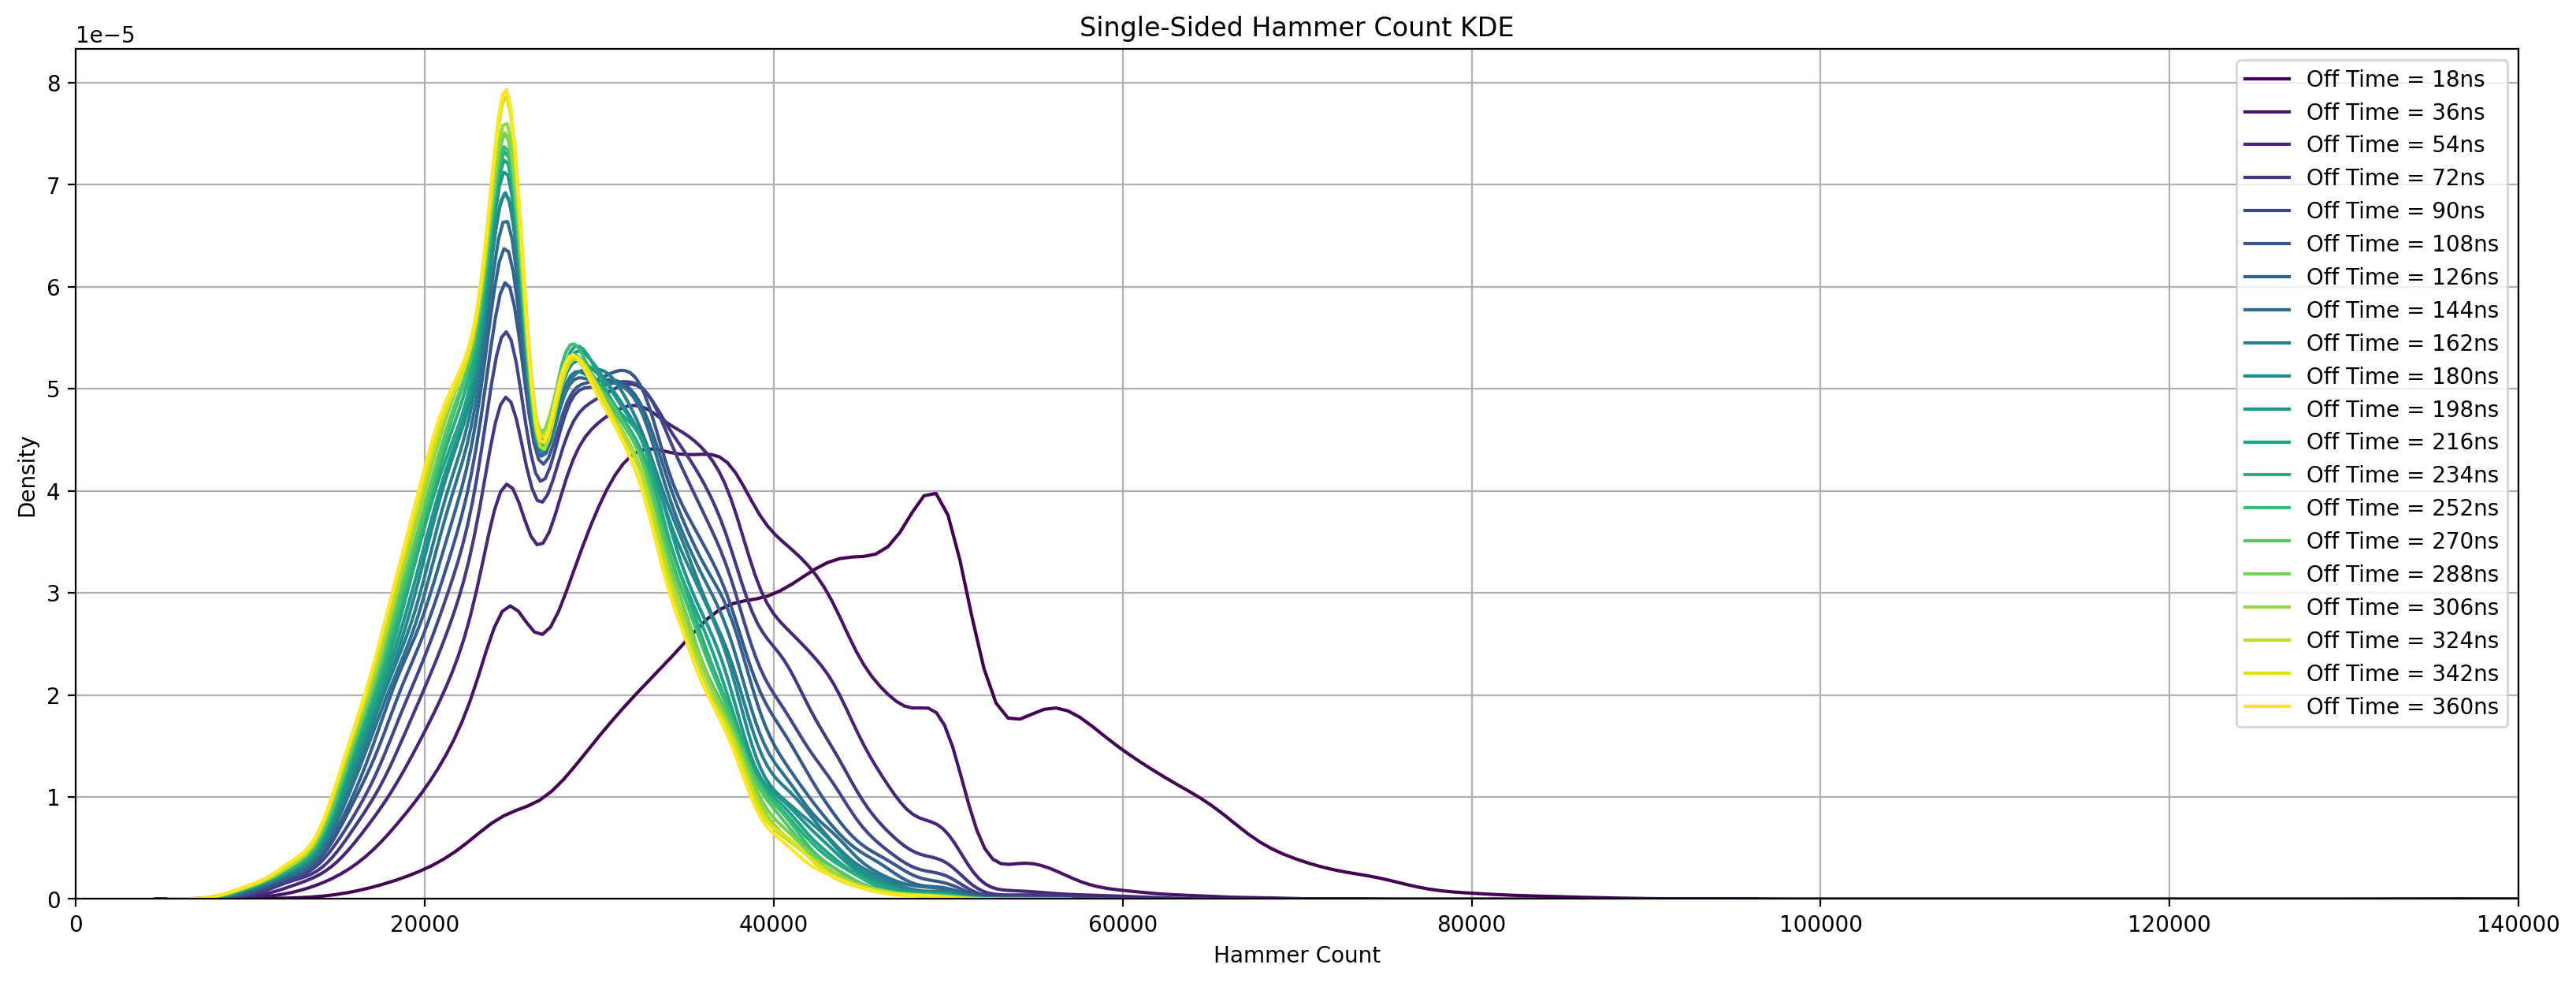

In [ ]:
plot_kde(ss, "linear", title="Single-Sided Hammer Count KDE")

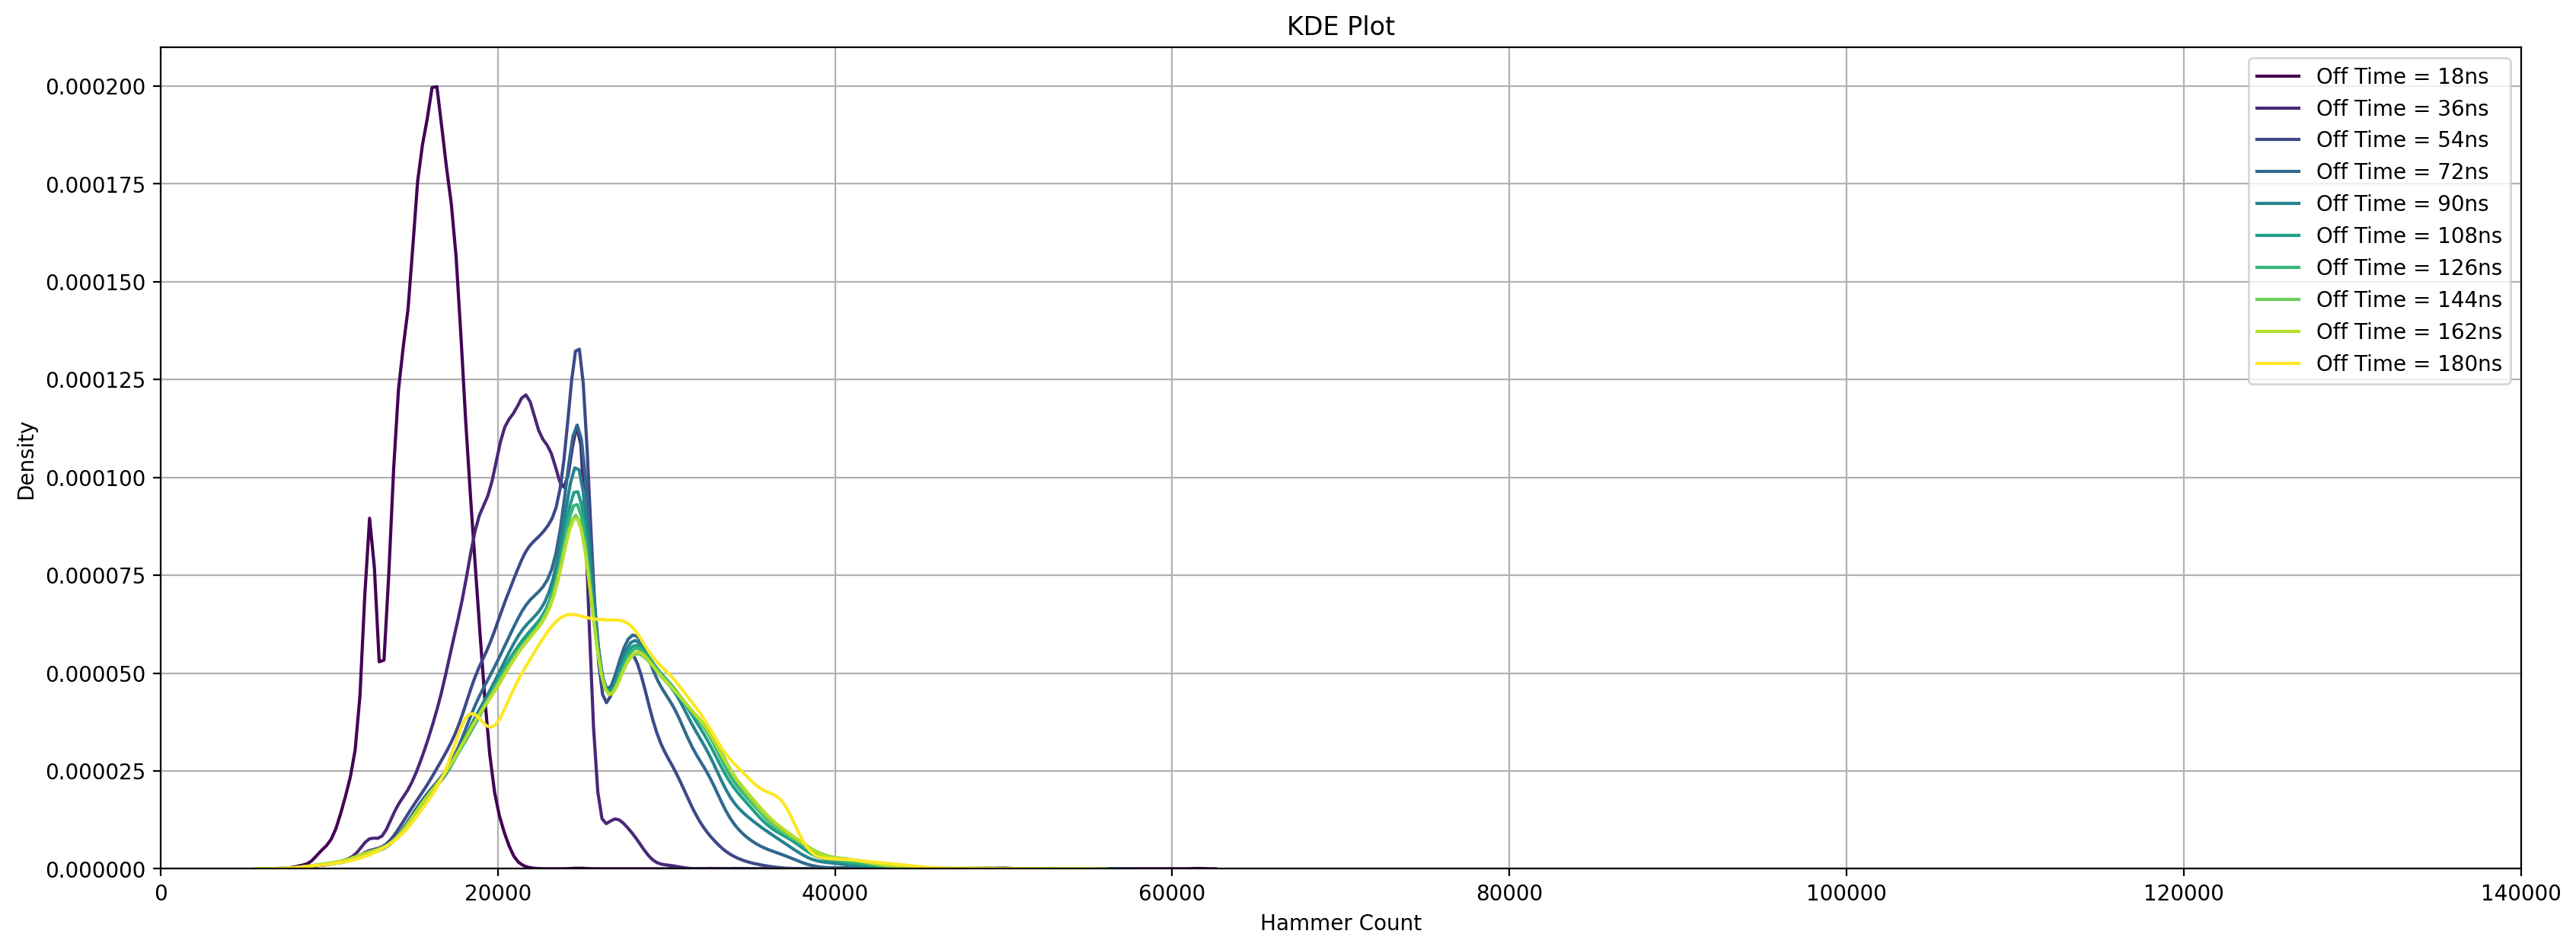

In [ ]:
plot_kde(ds)

# MC Plot

### RowHammer

In [ ]:
# Expected format *.cir.prn : <off time>
ss_dict = {}
ds_dict = {}

In [ ]:
def get_off_time(df_dict):
    d= pd.DataFrame()
    for folder,off_time in df_dict.items():
        file = f"{folder}/variation_table.csv"
        df_temp = pd.read_csv(file, )
        df_temp["offtime"] = off_time

        # Merge all dataframes into one and assign to d.
        d = pd.concat([df_temp,d], ignore_index=True)
    return d

In [ ]:
ss_df = get_off_time(ss_dict)
ss_df.dropna(inplace=True)
ss_df.reset_index(drop=True, inplace=True)


In [ ]:
ds_df = get_off_time(ds_dict)
# ds_df['HCfirst']/=2
ds_df.dropna(inplace=True)
ds_df.reset_index(drop=True, inplace=True)

In [ ]:
def offtime_plot(df, title="Off Time Plot", lim=None):
    unique_offtimes = np.sort(df["offtime"].unique())
    palette = sns.color_palette("viridis", len(unique_offtimes))
    fig, ax = plt.subplots(len(unique_offtimes), 1, figsize=(10,8))
    if lim is None:
        # Set the limit to the maximum HCfirst value across all off times
        lim = df["HCfirst"].max() 
    for i, off_time in enumerate(unique_offtimes):
        subset = df[df["offtime"] == off_time]
        sns.histplot(subset["HCfirst"], ax=ax[i], bins=100, color=palette[i])
        ax[i].set_title(f"Off Time: {off_time} ns")
        ax[i].set_xlabel("HCfirst Value")
        ax[i].set_ylabel("Density")
        ax[i].set_xlim(0, lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()


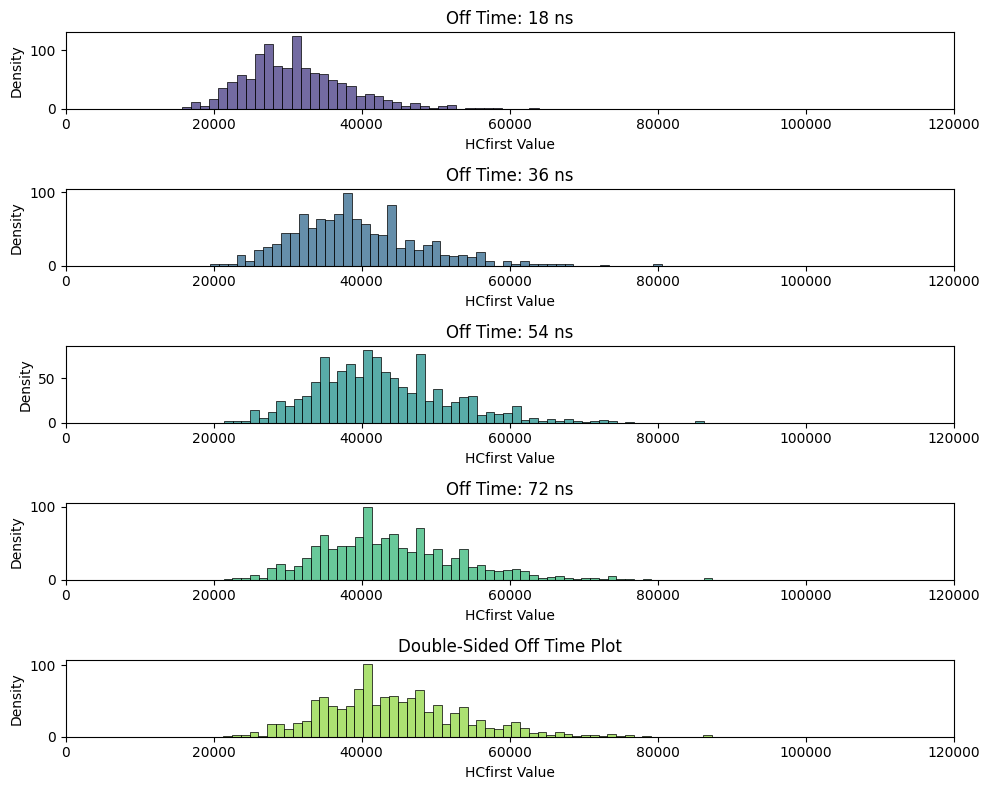

In [ ]:
offtime_plot(ds_df, title="Double-Sided Off Time Plot", lim=120000)

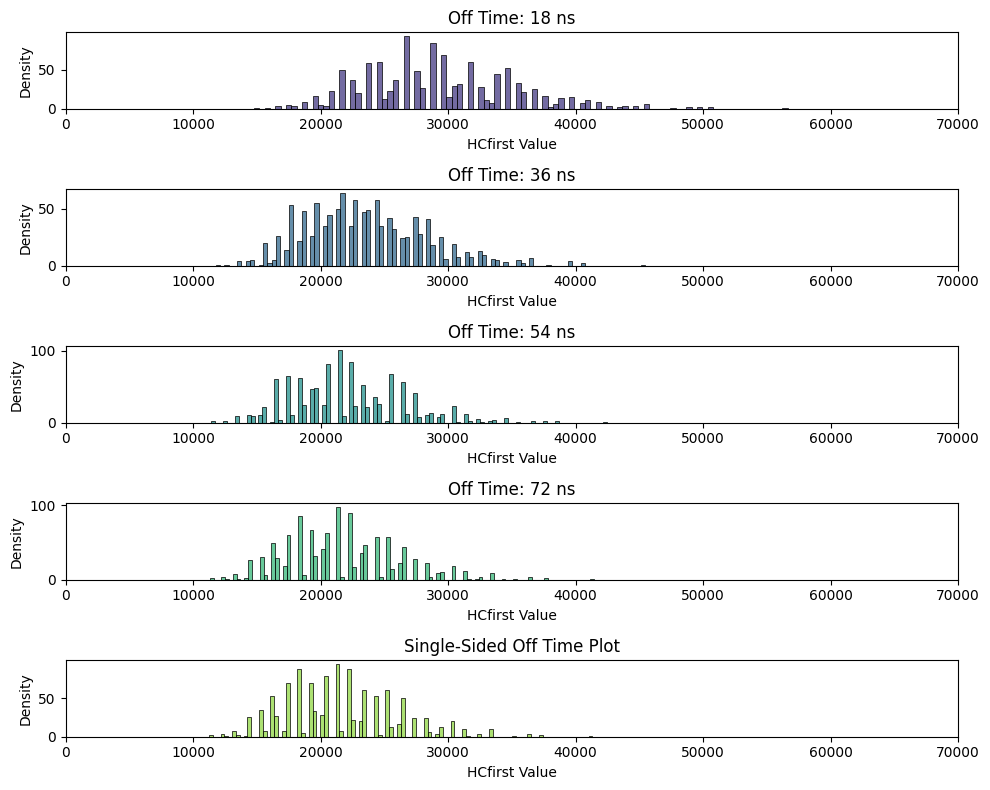

In [ ]:
offtime_plot(ss_df, title="Single-Sided Off Time Plot", lim=70000)

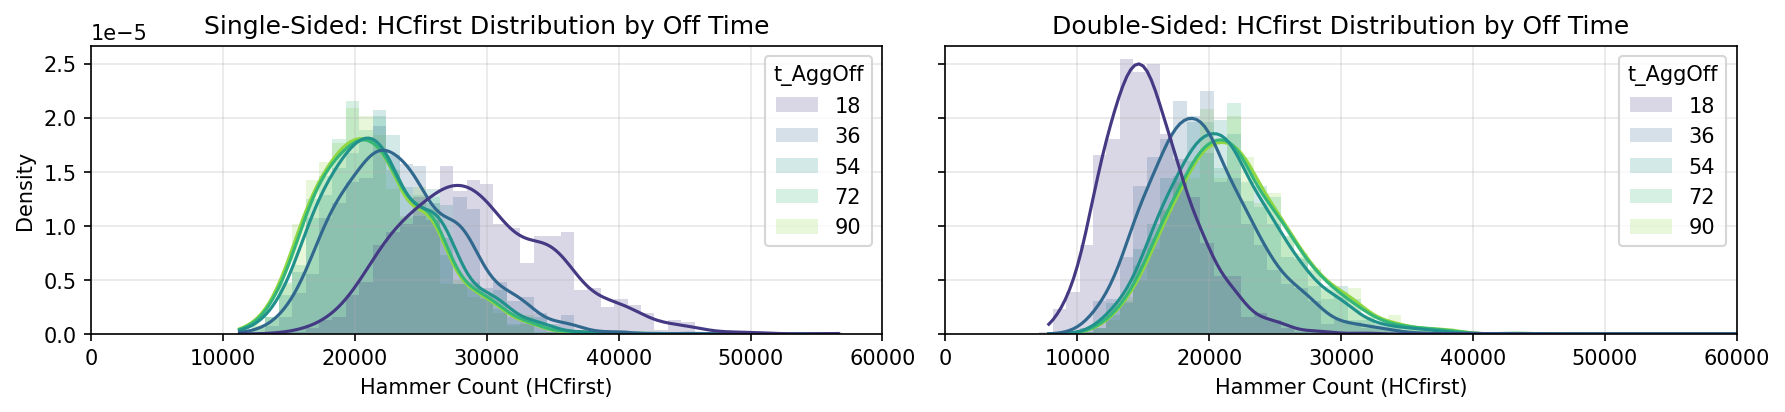

In [275]:
# Plot side-by-side histograms for Single-Sided (left) and Double-Sided (right)
# using existing ss_df and ds_df DataFrames.

# compute shared x-axis limits and common bins
max_hc = 60_000
min_hc = 0
bins = np.linspace(0, max_hc, 60)

fig, axes = plt.subplots(1, 2, figsize=(12, 3), dpi = 150, sharey=True)

# Single-Sided panel (left)
unique_ss = np.sort(ss_df["t_AggOff"].unique())
palette_ss = sns.color_palette("viridis", len(unique_ss))
sns.histplot(
    data=ss_df,
    x="HCfirst",
    hue="t_AggOff",
    bins=bins,
    ax=axes[0],
    element="step",
    stat="density",
    palette=palette_ss,
    legend=True,
    alpha=0.2,
    kde=True,
    edgecolor =None
)
axes[0].set_title("Single-Sided: HCfirst Distribution by Off Time")
axes[0].set_xlabel("Hammer Count (HCfirst)")
axes[0].set_ylabel("Density")
axes[0].set_xlim(min_hc, max_hc)
axes[0].grid(alpha=0.3)

# Double-Sided panel (right)
unique_ds = np.sort(ds_df["t_AggOff"].unique())
palette_ds = sns.color_palette("viridis", len(unique_ds))
sns.histplot(
    data=ds_df,
    x="HCfirst",
    hue="t_AggOff",
    bins=bins,
    ax=axes[1],
    element="step",
    legend=True,
    stat="density",
    palette=palette_ds,
    alpha=0.2,
    kde=True,
    edgecolor=None
)
axes[1].set_title("Double-Sided: HCfirst Distribution by Off Time")
axes[1].set_xlabel("Hammer Count (HCfirst)")
axes[1].set_xlim(min_hc, max_hc)
axes[1].grid(alpha=0.3)

# place a single legend on the right that applies to both panels
handles, labels = axes[1].get_legend_handles_labels()
plt.tight_layout()
plt.show()

In [ ]:
def bhattacharyya_coeff(exp_data, sim_data, n_bins=40):
    """
    Compute the Bhattacharyya coefficient between two sample sets.
    
    Parameters
    ----------
    exp_data : array-like
        1D array of experimental samples.
    sim_data : array-like
        1D array of simulated samples.
    n_bins : int
        Number of bins to use for the histogram (default 40).
    
    Returns
    -------
    BC : float
        Bhattacharyya coefficient in [0,1], where 1 means identical distributions.
    """
    # 1) compute common histogram bin edges:
    mn = min(np.min(exp_data), np.min(sim_data))
    mx = max(np.max(exp_data), np.max(sim_data))
    edges = np.linspace(mn, mx, n_bins + 1)
    
    # 2) compute normalized histograms (PDF estimates)
    p_exp, _ = np.histogram(exp_data, bins=edges, density=True)
    p_sim, _ = np.histogram(sim_data, bins=edges, density=True)
    
    # 3) Bhattacharyya coefficient = sum sqrt(p_exp * p_sim) * bin_width
    bin_width = edges[1] - edges[0]
    BC = np.sum(np.sqrt(p_exp * p_sim)) * bin_width
    return BC



In [ ]:
ss_df = get_off_time(ss_dict)
ss_df_min = ss_df.groupby(["sample_id", "victim_row", "offtime"]).agg({"HCfirst": "min"}).reset_index()

for t in ss_df["offtime"].unique():
    exp_data = ss.loc[ss["Off Time"]==t, "Hammer Count"].values
    sim_data = ss_df_min.loc[ss_df_min["offtime"]==t, "HCfirst"].values
    BC = bhattacharyya_coeff(exp_data, sim_data, n_bins=20)
    print(f"Off Time {t} ns: Bhattacharyya coefficient = {BC:.4f}")

### Rowpress

In [ ]:
# Expected format *.cir.prn : (<on time>, <temperature>)
rp_dict = {}

In [ ]:
def get_on_time(df_dict):
    d= pd.DataFrame()
    for folder,(on_time,temp) in df_dict.items():
        file = f"{folder}/variation_table.csv"
        df_temp = pd.read_csv(file, )
        df_temp["on_time"] = on_time
        df_temp["temp"] = temp

        # Merge all dataframes into one and assign to d.
        d = pd.concat([df_temp,d], ignore_index=True)
    return d

In [ ]:
rp_df = get_on_time(rp_dict)
rp_df['Flip Time'] = rp_df['on_time'] * rp_df['HCfirst'] 

In [ ]:
def ontime_plot(df, title="Off Time Plot"):
    unique_ontimes = np.sort(df["on_time"].unique())
    palette = sns.color_palette("viridis", len(unique_ontimes))
    fig, ax = plt.subplots(len(unique_ontimes), 1, figsize=(10,16))
    lim = df["HCfirst"].max() 
    for i, on_time in enumerate(unique_ontimes):
        subset = df[df["on_time"] == on_time]
        sns.histplot(subset["HCfirst"], ax=ax[i], bins=100, color=palette[i], multiple="stack")
        ax[i].set_title(f"On Time: {on_time} ns")
        ax[i].set_xlabel("HCfirst Value")
        ax[i].set_ylabel("Density")
        ax[i].set_xlim(0, lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()


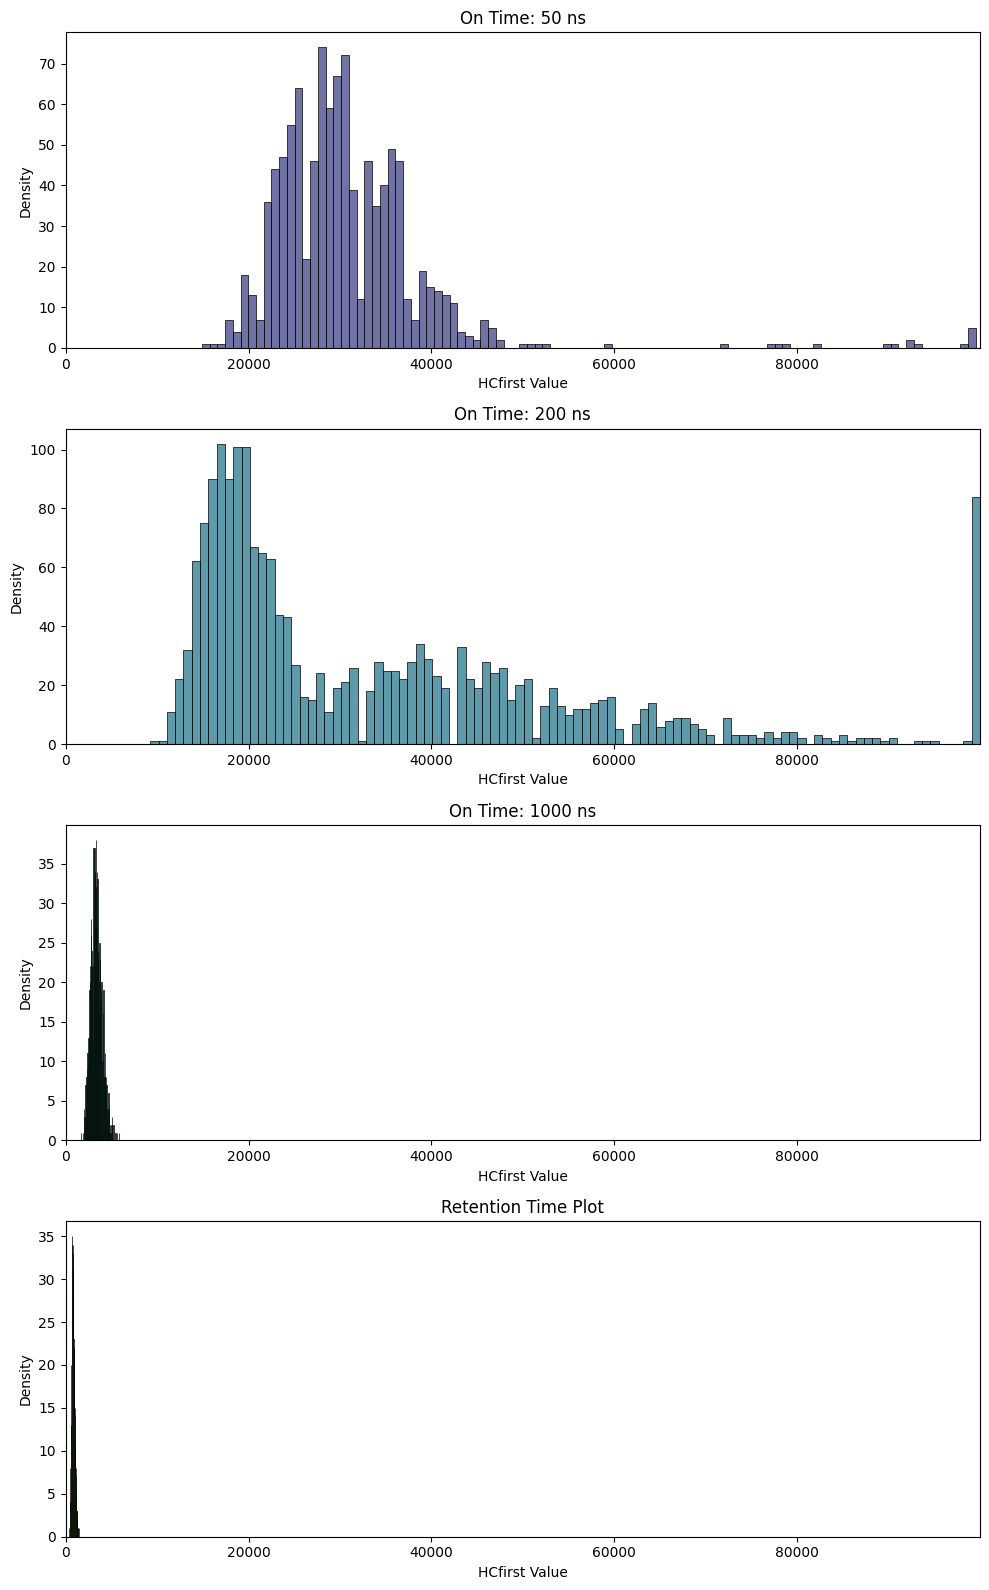

In [ ]:
ontime_plot(rp_df[rp_df['temp']==50], title="Retention Time Plot")

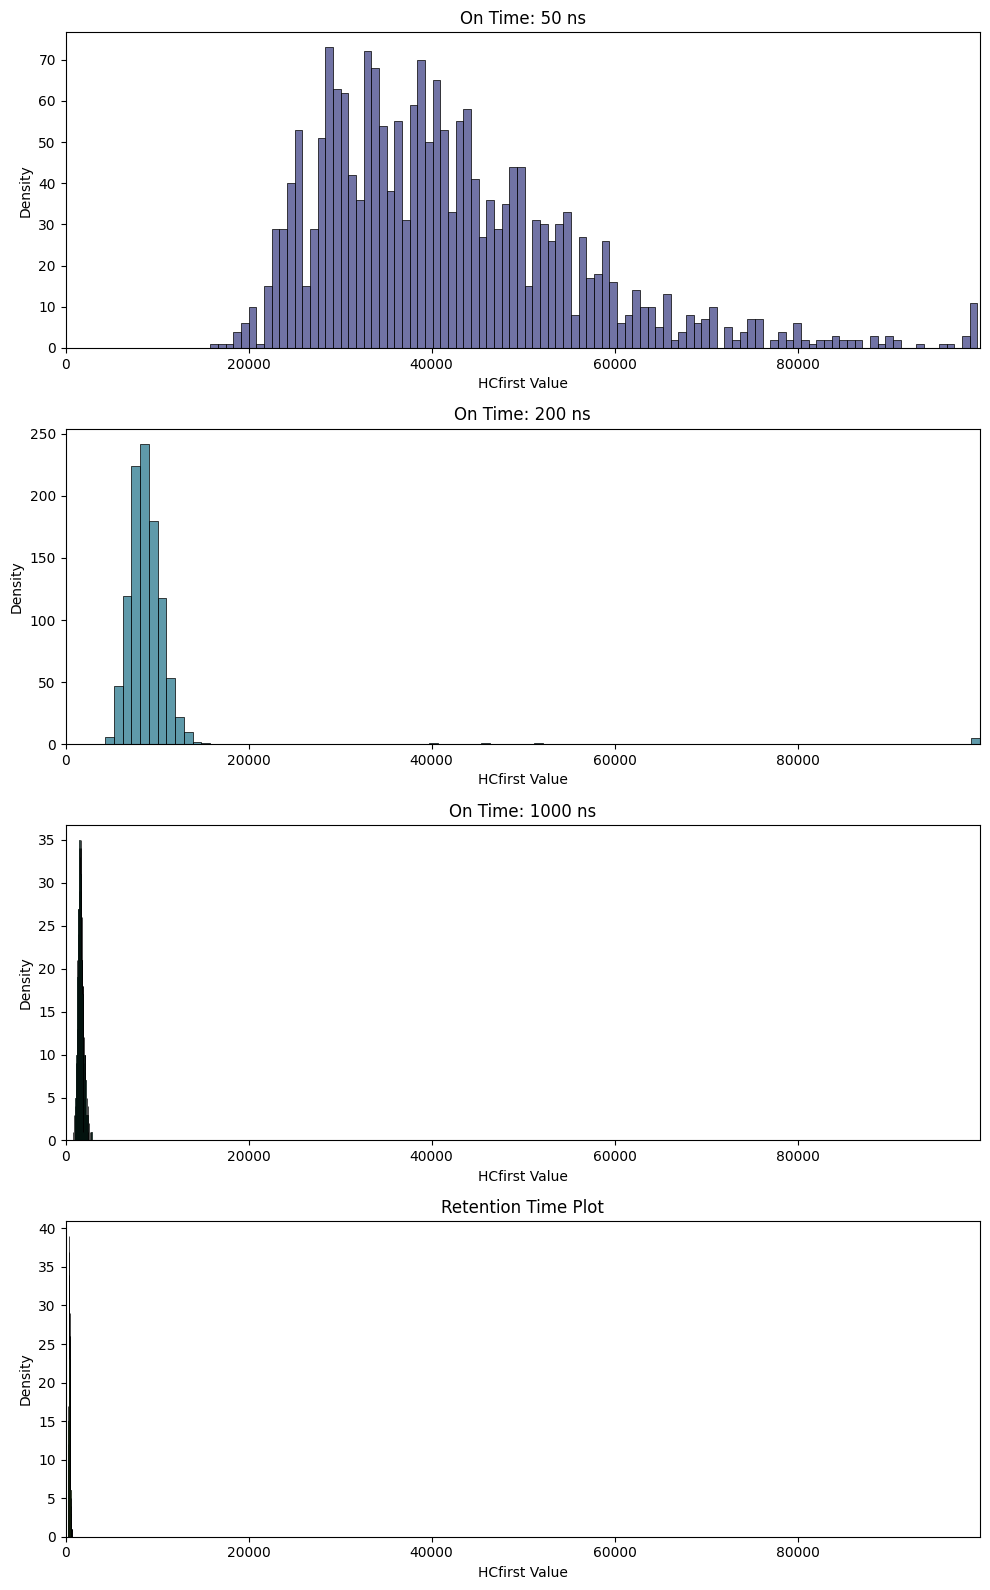

In [ ]:
ontime_plot(rp_df[rp_df['temp']==80], title="Retention Time Plot")

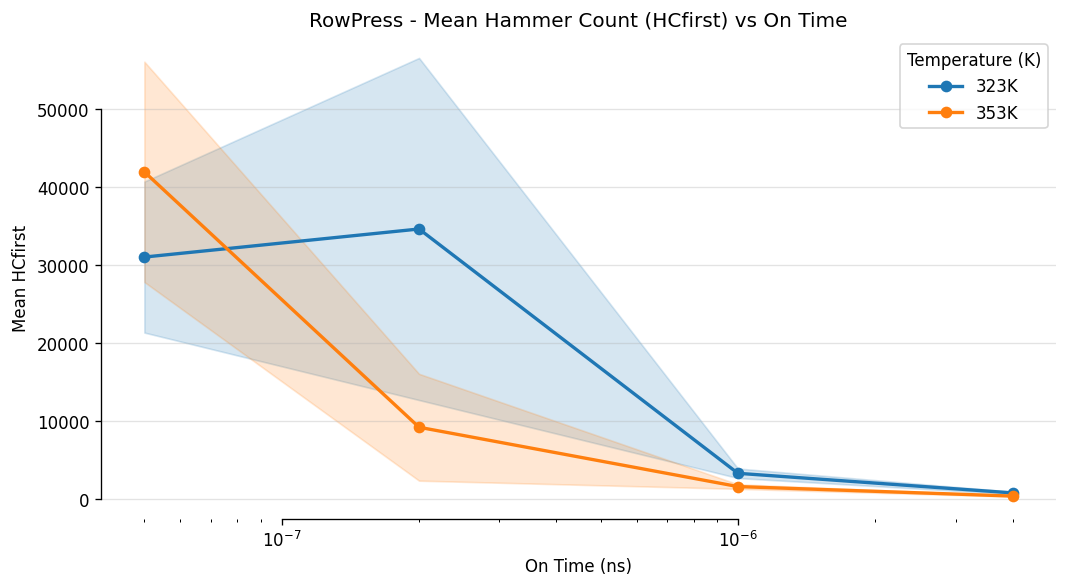

In [308]:
# nicer plot of mean HCfirst vs on_time by temperature with +/-1 std shaded
grp = rp_df.groupby(['on_time', 'temp'])['HCfirst'].agg(['mean', 'std']).reset_index()
pivot_mean = grp.pivot(index='on_time', columns='temp', values='mean').sort_index()
pivot_std  = grp.pivot(index='on_time', columns='temp', values='std').reindex(pivot_mean.index)

fig, ax = plt.subplots(figsize=(9, 5), dpi=120)

colors = sns.color_palette("tab10", n_colors=pivot_mean.shape[1])
for (col, color) in zip(pivot_mean.columns, colors):
    y = pivot_mean[col]
    yerr = pivot_std[col]
    ax.plot(pivot_mean.index, y, marker='o', linestyle='-', linewidth=2, markersize=6, color=color, label=f"{col}K")
    # shaded ±1 std region if available
    if yerr.notna().any():
        ax.fill_between(pivot_mean.index, y - yerr, y + yerr, color=color, alpha=0.18)

# cosmetics
ax.set_xlabel("On Time (ns)")
ax.set_ylabel("Mean HCfirst")
ax.set_title("RowPress - Mean Hammer Count (HCfirst) vs On Time")
ax.set_xticks(pivot_mean.index)
ax.set_xticklabels([int(x) for x in pivot_mean.index])
ax.grid(axis='y', alpha=0.35)
ax.legend(title="Temperature (K)", loc='best', frameon=True)
ax.set_xscale('log')
sns.despine(trim=True)
plt.tight_layout()
plt.show()

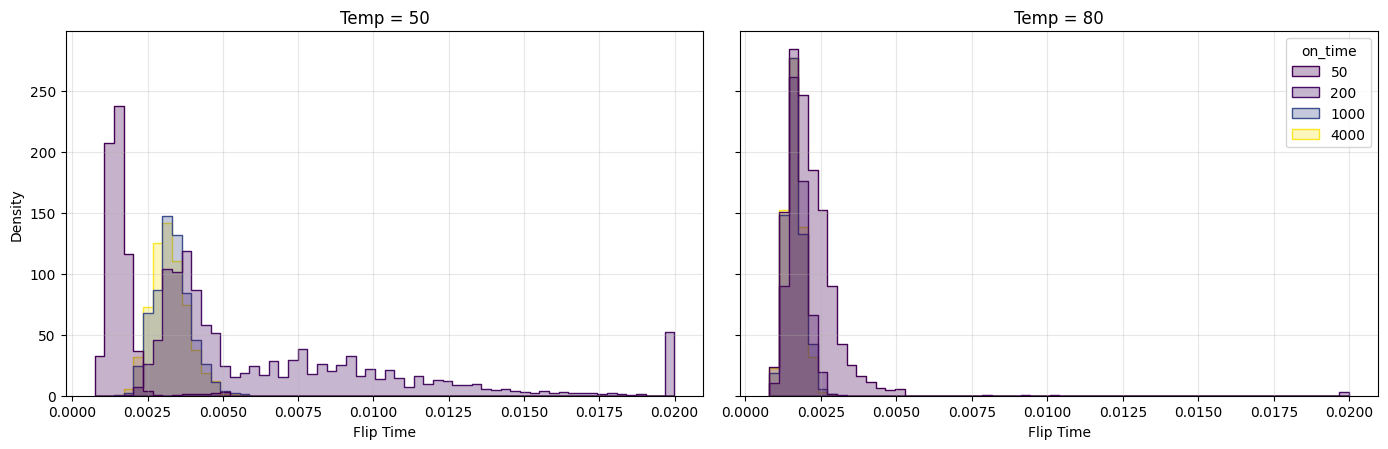

In [296]:
# 1x2 subplot: left temp=50, right temp=80. hue = on_time. include title, caption and a single legend.
subset50 = rp_df[rp_df["temp"] == 50]
subset80 = rp_df[rp_df["temp"] == 80]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: temp 50
sns.histplot(data=subset50, x="Flip Time", hue="on_time",
             ax=axes[0], bins=60, element="step", stat="density",
             palette="viridis", alpha=0.3, legend=False)
axes[0].set_title("Temp = 50")
axes[0].set_ylabel("Density")
axes[0].grid(alpha=0.3)

# Right: temp 80 (create legend here, then move to fig-level)
sns.histplot(data=subset80, x="Flip Time", hue="on_time",
             ax=axes[1], bins=60, element="step", stat="density",
             palette="viridis", alpha=0.3, legend=True)
axes[1].set_title("Temp = 80")
axes[1].grid(alpha=0.3)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# End